<a href="https://colab.research.google.com/github/avaniishh123/COE-Internship-DL-Project/blob/main/COE_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# Verify upload
import os, shutil
from pathlib import Path

assert os.path.exists("/content/kaggle.json"), "❌ Upload failed. kaggle.json not found."

# Move kaggle.json to correct location
KAGGLE_DIR = Path("/root/.kaggle")
KAGGLE_DIR.mkdir(parents=True, exist_ok=True)

shutil.copy("/content/kaggle.json", KAGGLE_DIR / "kaggle.json")
os.chmod(KAGGLE_DIR / "kaggle.json", 0o600)

print("✅ kaggle.json uploaded and configured successfully!")


In [ ]:
# =========================
# BLOCK 2: DOWNLOAD + EXTRACT (CVC-ClinicDB & ETIS-Larib)
# =========================
import os, glob, zipfile, shutil
from pathlib import Path

DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# --- Download zips into /content/data ---
!kaggle datasets download -d balraj98/cvcclinicdb -p /content/data --force
!kaggle datasets download -d nguyenvoquocduong/etis-laribpolypdb -p /content/data --force

print("\n✅ Downloaded files:")
!ls -lh /content/data

# --- Extract all zip files found in /content/data ---
zip_files = sorted(glob.glob("/content/data/*.zip"))
print("\nFound zip files:", zip_files)

for z in zip_files:
    out_dir = "/content/data"
    with zipfile.ZipFile(z, "r") as zip_ref:
        zip_ref.extractall(out_dir)
    print("✅ Extracted:", Path(z).name)

print("\n✅ Extraction complete. Showing folders (depth<=3):")
!find /content/data -maxdepth 3 -type d | sed -e 's|^| - |' | head -n 200

# --- Quick sanity: count image-like + mask-like files ---
img_exts = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
all_imgs = [p for p in glob.glob("/content/data/**/*", recursive=True) if p.lower().endswith(img_exts)]
print(f"\nTotal image-like files found: {len(all_imgs)}")

# A rough heuristic: masks often contain 'mask'/'ground truth'/'gt' in their path/name
mask_like = [p for p in all_imgs if any(k in p.lower() for k in ["mask", "ground", "truth", "gt"])]
print(f"Mask-like files (heuristic): {len(mask_like)}")
print("\nExample paths:")
for p in (all_imgs[:5] + mask_like[:5]):
    print(" -", p)


Dataset URL: https://www.kaggle.com/datasets/balraj98/cvcclinicdb
License(s): other
 98% 128M/131M [00:00<00:00, 1.34GB/s]
100% 131M/131M [00:00<00:00, 1.33GB/s]
Dataset URL: https://www.kaggle.com/datasets/nguyenvoquocduong/etis-laribpolypdb
License(s): unknown
 58% 103M/177M [00:00<00:00, 1.07GB/s]
100% 177M/177M [00:00<00:00, 912MB/s] 

✅ Downloaded files:
total 308M
-rw-r--r-- 1 root root 132M Oct 20  2020 cvcclinicdb.zip
-rw-r--r-- 1 root root 177M Apr  3  2024 etis-laribpolypdb.zip

Found zip files: ['/content/data/cvcclinicdb.zip', '/content/data/etis-laribpolypdb.zip']
✅ Extracted: cvcclinicdb.zip
✅ Extracted: etis-laribpolypdb.zip

✅ Extraction complete. Showing folders (depth<=3):
 - /content/data
 - /content/data/masks
 - /content/data/images
 - /content/data/PNG
 - /content/data/PNG/Ground Truth
 - /content/data/PNG/Original
 - /content/data/TIF
 - /content/data/TIF/Ground Truth
 - /content/data/TIF/Original

Total image-like files found: 2840
Mask-like files (heuristic): 1

In [ ]:
# =========================
# FIX: Extract ETIS inner zip files
# =========================
import zipfile, glob

etis_zips = [z for z in glob.glob("/content/data/*.zip") if "etis" in z.lower() or "larib" in z.lower()]

print("Found ETIS zip(s):", etis_zips)

for z in etis_zips:
    with zipfile.ZipFile(z, "r") as zip_ref:
        zip_ref.extractall("/content/data/ETIS_RAW")
        print("✅ Extracted inner ETIS zip:", z)

print("\n📂 Showing ETIS_RAW folder contents:")
!find /content/data/ETIS_RAW -maxdepth 4 -type d | sed -e 's|^| - |'


Found ETIS zip(s): ['/content/data/etis-laribpolypdb.zip']
✅ Extracted inner ETIS zip: /content/data/etis-laribpolypdb.zip

📂 Showing ETIS_RAW folder contents:
 - /content/data/ETIS_RAW
 - /content/data/ETIS_RAW/masks
 - /content/data/ETIS_RAW/images


In [ ]:
# =========================
# BLOCK 5: GRL + DANN SEGMENTATION MODEL
# =========================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50


# -------------------------------------------
# GRADIENT REVERSAL LAYER
# -------------------------------------------

class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None


def grad_reverse(x, alpha):
    return GradReverse.apply(x, alpha)


# -------------------------------------------
# DANN MODEL ARCHITECTURE
# -------------------------------------------

class DANN_Segmentation(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        # Base DeepLabV3 segmentation network
        self.seg_model = deeplabv3_resnet50(pretrained=True)
        self.seg_model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

        # Domain classifier head
        self.domain_classifier = nn.Sequential(
            nn.Linear(256 * 16 * 16, 1024),   # feature size after DLv3 ASPP
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)   # 2 domains: source / target
        )

    def forward(self, x, alpha=0.0):

        # -----------------------
        # 1. SEGMENTATION OUTPUT
        # -----------------------
        out = self.seg_model(x)
        seg_pred = out["out"]  # shape: [B, 1, H, W]

        # -----------------------
        # 2. DOMAIN CLASSIFICATION
        # -----------------------
        feats = out["out"]  # DeepLab output feature map
        pooled = F.adaptive_avg_pool2d(feats, (16, 16))  # reduce size
        flat = pooled.view(pooled.size(0), -1)

        # Apply GRL
        rev = grad_reverse(flat, alpha)

        domain_pred = self.domain_classifier(rev)

        return seg_pred, domain_pred


In [ ]:
# =========================
# BLOCK 7.1: VALIDATION FUNCTION
# =========================

def validate_model(model, val_loader):
    model.eval()
    dices = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            preds, _ = model(imgs, alpha=0)

            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()

            intersection = (preds * masks).sum(dim=(2, 3))
            union = preds.sum(dim=(2, 3)) + masks.sum(dim=(2, 3))

            dice = (2 * intersection + 1e-6) / (union + 1e-6)
            dices.extend(dice.cpu().numpy())

    return sum(dices) / len(dices)


In [ ]:
# =========================
# PATCH: FIXED DANN MODEL (use backbone features for domain classifier)
# =========================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabV3_ResNet50_Weights

# -------- GRL --------
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

def grad_reverse(x, alpha):
    return GradReverse.apply(x, alpha)

# -------- DANN Model --------
class DANN_Segmentation(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        weights = DeepLabV3_ResNet50_Weights.DEFAULT
        self.seg_model = deeplabv3_resnet50(weights=weights)

        # Replace classifier last conv to output 1 channel (binary mask)
        self.seg_model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

        # Backbone output channels for ResNet50 in DeepLabV3 = 2048
        feat_ch = 2048

        # Domain classifier on pooled backbone features
        self.domain_classifier = nn.Sequential(
            nn.Linear(feat_ch, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)  # source vs target
        )

    def forward(self, x, alpha=0.0):
        input_size = x.shape[-2:]

        # 1) Extract backbone features
        feats = self.seg_model.backbone(x)          # dict
        f = feats["out"]                            # [B, 2048, H/16, W/16]

        # 2) Segmentation head
        seg_low = self.seg_model.classifier(f)      # [B, 1, h, w]
        seg_pred = F.interpolate(seg_low, size=input_size, mode="bilinear", align_corners=False)

        # 3) Domain head (global avg pool -> [B, 2048])
        pooled = F.adaptive_avg_pool2d(f, (1, 1)).flatten(1)
        rev = grad_reverse(pooled, alpha)
        domain_pred = self.domain_classifier(rev)

        return seg_pred, domain_pred


In [ ]:
# =========================
# PATCH: REINIT MODEL + OPTIMIZER (required after redefining class)
# =========================

import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
model = DANN_Segmentation(num_classes=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

print("✅ Model + optimizer reset with fixed domain head!")


✅ Model + optimizer reset with fixed domain head!


In [ ]:
# =========================
# SPEED PATCH: Smaller input size (T4 friendly) + rebuild loaders
# =========================

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

IMG_SIZE = 224  # try 224; if still slow, try 192

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.4),
    A.ColorJitter(p=0.3),
    A.GaussianBlur(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Re-split (same as before)
train_pairs, val_pairs = train_test_split(source_pairs, test_size=0.2, random_state=42)

# Rebuild datasets with new transforms
train_ds = PolypDataset(train_pairs, transform=train_transform)
val_ds   = PolypDataset(val_pairs, transform=val_transform)
target_ds = TargetDataset(target_imgs, transform=train_transform)

# Rebuild dataloaders (keep batch_size=8 safe for T4)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
target_loader = DataLoader(target_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

print(f"✅ Updated transforms to {IMG_SIZE}x{IMG_SIZE} and rebuilt loaders.")
print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Target batches: {len(target_loader)}")


✅ Updated transforms to 224x224 and rebuilt loaders.
Train batches: 142 | Val batches: 36 | Target batches: 25


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
# =========================
# PATCH: validate_model returns float (not numpy array)
# =========================

import numpy as np
import torch

def validate_model(model, val_loader):
    model.eval()
    dices = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            preds, _ = model(imgs, alpha=0.0)

            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()

            intersection = (preds * masks).sum(dim=(2, 3))
            union = preds.sum(dim=(2, 3)) + masks.sum(dim=(2, 3))

            dice = (2 * intersection + 1e-6) / (union + 1e-6)  # [B,1]
            dices.extend(dice.detach().cpu().numpy().reshape(-1).tolist())

    return float(np.mean(dices))


In [ ]:
import math
from tqdm import tqdm
import torch

def dann_train_resume(
    model,
    train_loader,
    target_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs=12,
    save_every_epoch=True,
    ckpt_path=None,
    best_path=None,
    resume=True
):
    # ---- safe defaults set at runtime ----
    if ckpt_path is None:
        ckpt_path = CKPT_PATH
    if best_path is None:
        best_path = BEST_PATH

    # ---- optionally resume ----
    if resume:
        start_epoch, best_dice, extra = load_ckpt(model, optimizer, scheduler, ckpt_path, device=device)
    else:
        start_epoch, best_dice, extra = 1, 0.0, {}

    for epoch in range(start_epoch, num_epochs + 1):
        model.train()
        target_iter = iter(target_loader)

        progress = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")

        for src_imgs, src_masks in progress:
            p = float(epoch) / float(num_epochs)
            alpha = 2.0 / (1.0 + math.exp(-10 * p)) - 1.0

            src_imgs = src_imgs.to(device)
            src_masks = src_masks.to(device)

            seg_pred, src_domain_pred = model(src_imgs, alpha=float(alpha))
            seg_loss = segmentation_loss(seg_pred, src_masks)

            src_domain_labels = torch.zeros(src_imgs.size(0), dtype=torch.long, device=device)
            dom_loss_src = domain_loss_fn(src_domain_pred, src_domain_labels)

            try:
                tgt_imgs = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                tgt_imgs = next(target_iter)

            tgt_imgs = tgt_imgs.to(device)
            _, tgt_domain_pred = model(tgt_imgs, alpha=float(alpha))

            tgt_domain_labels = torch.ones(tgt_imgs.size(0), dtype=torch.long, device=device)
            dom_loss_tgt = domain_loss_fn(tgt_domain_pred, tgt_domain_labels)

            domain_loss = dom_loss_src + dom_loss_tgt
            loss = seg_loss + 0.1 * domain_loss

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            progress.set_postfix({
                "SegLoss": f"{seg_loss.item():.4f}",
                "DomLoss": f"{domain_loss.item():.4f}",
                "Alpha": f"{alpha:.2f}"
            })

        if scheduler is not None:
            scheduler.step()

        val_dice = validate_model(model, val_loader)
        print(f"📌 Epoch {epoch} — Val Dice: {val_dice:.4f} | Best: {best_dice:.4f}")

        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), best_path)
            print(f"🏆 Saved BEST model to: {best_path}")

        if save_every_epoch:
            save_ckpt(epoch, model, optimizer, scheduler, best_dice, extra={"img_size": "current"}, path=ckpt_path)

    print("\n✅ Training finished.")
    print(f"Best Val Dice: {best_dice:.4f}")
    return best_dice


In [ ]:
# =========================
# COLAB CHECKPOINTING: Save to Google Drive + Resume
# =========================

from google.colab import drive
drive.mount("/content/drive")

import os, torch

CKPT_DIR = "/content/drive/MyDrive/polyp_dann_checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

CKPT_PATH = os.path.join(CKPT_DIR, "dann_deeplabv3_ckpt.pth")
BEST_PATH = os.path.join(CKPT_DIR, "best_dann_deeplabv3.pth")

def save_ckpt(epoch, model, optimizer, scheduler, best_dice, extra=None, path=CKPT_PATH):
    ckpt = {
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict() if scheduler is not None else None,
        "best_dice": float(best_dice),
        "extra": extra or {}
    }
    torch.save(ckpt, path)
    print(f"💾 Checkpoint saved: {path} (epoch={epoch}, best_dice={best_dice:.4f})")

def load_ckpt(model, optimizer=None, scheduler=None, path=CKPT_PATH, device="cuda"):
    if not os.path.exists(path):
        print("ℹ️ No checkpoint found. Starting fresh.")
        return 1, 0.0, {}

    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model"])

    if optimizer is not None and "optimizer" in ckpt and ckpt["optimizer"] is not None:
        optimizer.load_state_dict(ckpt["optimizer"])

    if scheduler is not None and ckpt.get("scheduler", None) is not None:
        scheduler.load_state_dict(ckpt["scheduler"])

    start_epoch = int(ckpt["epoch"]) + 1
    best_dice = float(ckpt.get("best_dice", 0.0))
    extra = ckpt.get("extra", {})
    print(f"✅ Resumed from {path} | next_epoch={start_epoch} | best_dice={best_dice:.4f}")
    return start_epoch, best_dice, extra


Mounted at /content/drive


In [ ]:
# =========================
# RESUME TRAINING LOOP (safe for Colab disconnects)
# =========================

import math
from tqdm import tqdm
import torch

def dann_train_resume(
    model,
    train_loader,
    target_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs=12,
    save_every_epoch=True,
    ckpt_path=CKPT_PATH,
    best_path=BEST_PATH
):
    # Load checkpoint if exists
    start_epoch, best_dice, extra = load_ckpt(model, optimizer, scheduler, ckpt_path, device=device)

    for epoch in range(start_epoch, num_epochs + 1):
        model.train()
        target_iter = iter(target_loader)

        progress = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")

        for src_imgs, src_masks in progress:
            # Alpha schedule
            p = float(epoch) / float(num_epochs)
            alpha = 2.0 / (1.0 + math.exp(-10 * p)) - 1.0
            alpha = float(alpha)

            # Source batch
            src_imgs = src_imgs.to(device)
            src_masks = src_masks.to(device)

            seg_pred, src_domain_pred = model(src_imgs, alpha=alpha)
            seg_loss = segmentation_loss(seg_pred, src_masks)

            src_domain_labels = torch.zeros(src_imgs.size(0), dtype=torch.long, device=device)
            dom_loss_src = domain_loss_fn(src_domain_pred, src_domain_labels)

            # Target batch (unlabeled)
            try:
                tgt_imgs = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                tgt_imgs = next(target_iter)

            tgt_imgs = tgt_imgs.to(device)
            _, tgt_domain_pred = model(tgt_imgs, alpha=alpha)

            tgt_domain_labels = torch.ones(tgt_imgs.size(0), dtype=torch.long, device=device)
            dom_loss_tgt = domain_loss_fn(tgt_domain_pred, tgt_domain_labels)

            domain_loss = dom_loss_src + dom_loss_tgt

            # Total loss
            loss = seg_loss + 0.1 * domain_loss

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            progress.set_postfix({
                "SegLoss": f"{seg_loss.item():.4f}",
                "DomLoss": f"{domain_loss.item():.4f}",
                "Alpha": f"{alpha:.2f}"
            })

        if scheduler is not None:
            scheduler.step()

        # Validate
        val_dice = validate_model(model, val_loader)
        print(f"📌 Epoch {epoch} — Val Dice: {val_dice:.4f} | Best: {best_dice:.4f}")

        # Save best model weights
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), best_path)
            print(f"🏆 Saved BEST model to: {best_path}")

        # Save checkpoint (epoch-wise resume)
        if save_every_epoch:
            save_ckpt(epoch, model, optimizer, scheduler, best_dice, extra={"img_size": "current"}, path=ckpt_path)

    print("\n✅ Training finished.")
    print(f"Best Val Dice: {best_dice:.4f}")


In [ ]:
dann_train_resume(
    model,
    train_loader,
    target_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs=12,
    resume=True
)


ℹ️ No checkpoint found. Starting fresh.


Epoch 1/12: 100%|██████████| 142/142 [02:04<00:00,  1.14it/s, SegLoss=0.7367, DomLoss=1.4116, Alpha=0.39]


📌 Epoch 1 — Val Dice: 0.7452 | Best: 0.0000
🏆 Saved BEST model to: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3.pth
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt.pth (epoch=1, best_dice=0.7452)


Epoch 2/12: 100%|██████████| 142/142 [02:12<00:00,  1.07it/s, SegLoss=0.6309, DomLoss=1.3809, Alpha=0.68]


📌 Epoch 2 — Val Dice: 0.7968 | Best: 0.7452
🏆 Saved BEST model to: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3.pth
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt.pth (epoch=2, best_dice=0.7968)


Epoch 3/12: 100%|██████████| 142/142 [02:13<00:00,  1.07it/s, SegLoss=0.3884, DomLoss=1.3976, Alpha=0.85]


📌 Epoch 3 — Val Dice: 0.8238 | Best: 0.7968
🏆 Saved BEST model to: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3.pth
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt.pth (epoch=3, best_dice=0.8238)


Epoch 4/12: 100%|██████████| 142/142 [02:12<00:00,  1.07it/s, SegLoss=0.5205, DomLoss=1.4214, Alpha=0.93]


📌 Epoch 4 — Val Dice: 0.8253 | Best: 0.8238
🏆 Saved BEST model to: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3.pth
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt.pth (epoch=4, best_dice=0.8253)


Epoch 5/12: 100%|██████████| 142/142 [02:11<00:00,  1.08it/s, SegLoss=0.2457, DomLoss=1.3665, Alpha=0.97]


📌 Epoch 5 — Val Dice: 0.8400 | Best: 0.8253
🏆 Saved BEST model to: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3.pth
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt.pth (epoch=5, best_dice=0.8400)


Epoch 6/12: 100%|██████████| 142/142 [02:12<00:00,  1.07it/s, SegLoss=0.2607, DomLoss=1.3795, Alpha=0.99]


📌 Epoch 6 — Val Dice: 0.8378 | Best: 0.8400
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt.pth (epoch=6, best_dice=0.8400)


Epoch 7/12: 100%|██████████| 142/142 [02:11<00:00,  1.08it/s, SegLoss=0.2612, DomLoss=1.4102, Alpha=0.99]


📌 Epoch 7 — Val Dice: 0.8634 | Best: 0.8400
🏆 Saved BEST model to: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3.pth
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt.pth (epoch=7, best_dice=0.8634)


Epoch 8/12: 100%|██████████| 142/142 [02:12<00:00,  1.07it/s, SegLoss=0.2670, DomLoss=1.3883, Alpha=1.00]


📌 Epoch 8 — Val Dice: 0.8688 | Best: 0.8634
🏆 Saved BEST model to: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3.pth
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt.pth (epoch=8, best_dice=0.8688)


Epoch 9/12: 100%|██████████| 142/142 [02:12<00:00,  1.07it/s, SegLoss=0.1936, DomLoss=1.3743, Alpha=1.00]


📌 Epoch 9 — Val Dice: 0.8644 | Best: 0.8688
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt.pth (epoch=9, best_dice=0.8688)


Epoch 10/12: 100%|██████████| 142/142 [02:12<00:00,  1.07it/s, SegLoss=0.2427, DomLoss=1.3504, Alpha=1.00]


📌 Epoch 10 — Val Dice: 0.8705 | Best: 0.8688
🏆 Saved BEST model to: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3.pth
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt.pth (epoch=10, best_dice=0.8705)


Epoch 11/12: 100%|██████████| 142/142 [02:13<00:00,  1.07it/s, SegLoss=0.2457, DomLoss=1.4198, Alpha=1.00]


📌 Epoch 11 — Val Dice: 0.8537 | Best: 0.8705
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt.pth (epoch=11, best_dice=0.8705)


Epoch 12/12: 100%|██████████| 142/142 [02:11<00:00,  1.08it/s, SegLoss=0.2595, DomLoss=1.4356, Alpha=1.00]


📌 Epoch 12 — Val Dice: 0.8632 | Best: 0.8705
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt.pth (epoch=12, best_dice=0.8705)

✅ Training finished.
Best Val Dice: 0.8705


0.8704936709860006

In [ ]:
from pathlib import Path
import torch
from torch.utils.data import DataLoader

# 1) Load BEST model from Drive (recommended)
BEST_PATH = "/content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3.pth"
assert Path(BEST_PATH).exists(), f"❌ Best model not found at: {BEST_PATH}"

model.load_state_dict(torch.load(BEST_PATH, map_location=device))
model.eval()
print("✅ Loaded BEST model for ETIS evaluation")

# 2) Build ETIS pairs (eval only)
etis_img_dir  = Path("/content/data/ETIS_RAW/images")
etis_mask_dir = Path("/content/data/ETIS_RAW/masks")

def collect_pairs_simple(img_dir, mask_dir):
    img_exts = (".png",".jpg",".jpeg",".tif",".tiff",".bmp")
    masks = {m.stem.lower(): m for m in mask_dir.glob("*") if m.suffix.lower() in img_exts}
    pairs = []
    for im in img_dir.glob("*"):
        if im.suffix.lower() in img_exts and im.stem.lower() in masks:
            pairs.append((str(im), str(masks[im.stem.lower()])))
    return pairs

etis_pairs = collect_pairs_simple(etis_img_dir, etis_mask_dir)
print("ETIS eval pairs:", len(etis_pairs))

# 3) ETIS loader
etis_eval_ds = PolypDataset(etis_pairs, transform=val_transform)
etis_eval_loader = DataLoader(etis_eval_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# 4) Dice evaluation
etis_dice = validate_model(model, etis_eval_loader)
print(f"🌍 ETIS Dice (eval only, BEST model): {etis_dice:.4f}")

✅ Loaded BEST model for ETIS evaluation
ETIS eval pairs: 196
🌍 ETIS Dice (eval only, BEST model): 0.8275


In [ ]:
# =========================
# PATCH: define dice_iou
# =========================
import numpy as np

def dice_iou(pred_bin, gt_bin, eps=1e-6):
    pred_bin = pred_bin.astype(np.uint8)
    gt_bin = gt_bin.astype(np.uint8)

    inter = (pred_bin & gt_bin).sum()
    dice = (2 * inter + eps) / (pred_bin.sum() + gt_bin.sum() + eps)

    iou = (inter + eps) / ((pred_bin | gt_bin).sum() + eps)
    return float(dice), float(iou)


In [ ]:
# =========================
# EXTRA: ETIS Mean Dice + Mean IoU
# =========================
import numpy as np
import torch
import cv2

def eval_dice_iou_full(model, pairs, thr=0.5):
    dices, ious = [], []
    for img_path, mask_path in pairs:
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gt  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt  = (gt > 128).astype(np.uint8)

        aug = val_transform(image=img, mask=gt.astype(np.float32))
        x = aug["image"].unsqueeze(0).to(device)
        gt_t = aug["mask"].numpy().astype(np.uint8)

        with torch.no_grad():
            logits, _ = model(x, alpha=0.0)
            prob = torch.sigmoid(logits)[0,0].cpu().numpy()
            pred = (prob > thr).astype(np.uint8)

        d, j = dice_iou(pred, gt_t)
        dices.append(d); ious.append(j)

    return float(np.mean(dices)), float(np.mean(ious))

mean_dice, mean_iou = eval_dice_iou_full(model, etis_pairs, thr=0.4)
print(f"🌍 ETIS Mean Dice (thr=0.4): {mean_dice:.4f}")
print(f"🌍 ETIS Mean IoU  (thr=0.4): {mean_iou:.4f}")


🌍 ETIS Mean Dice (thr=0.4): 0.8211
🌍 ETIS Mean IoU  (thr=0.4): 0.7361


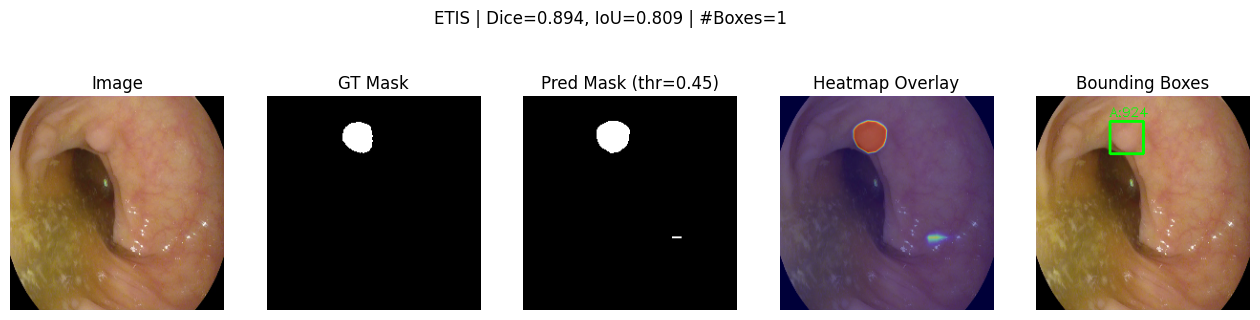

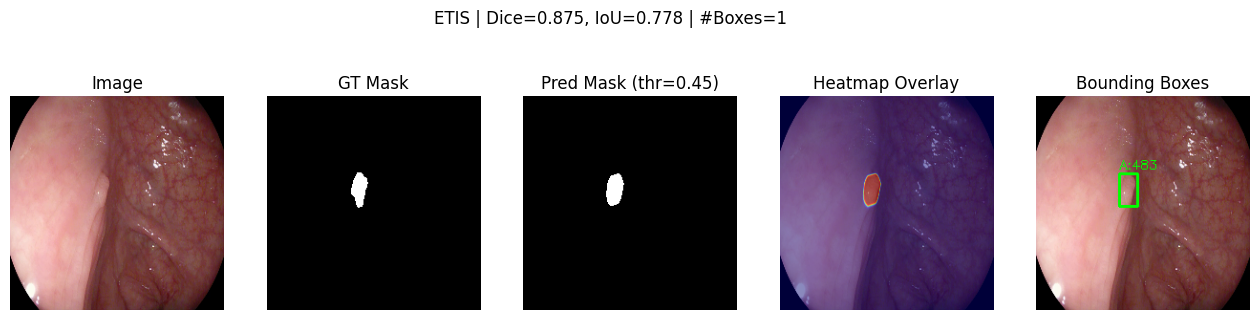

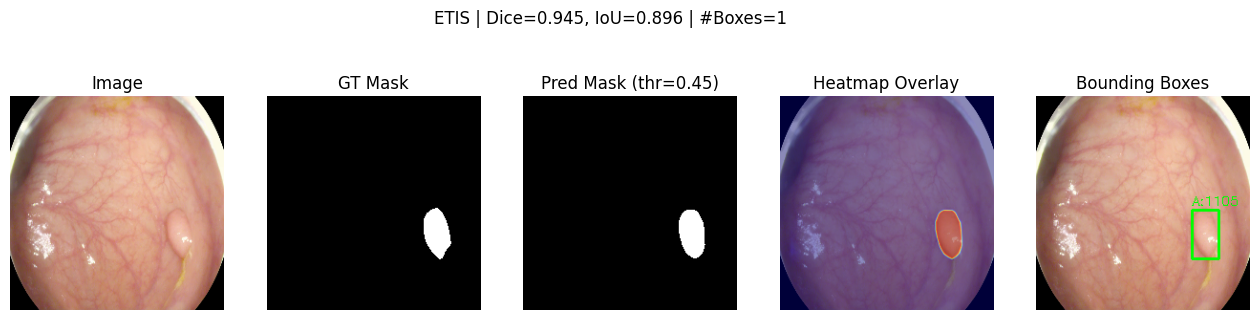

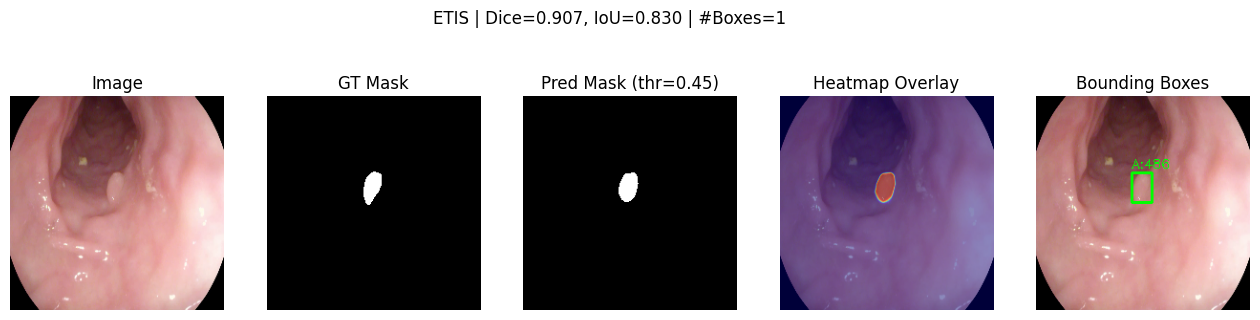

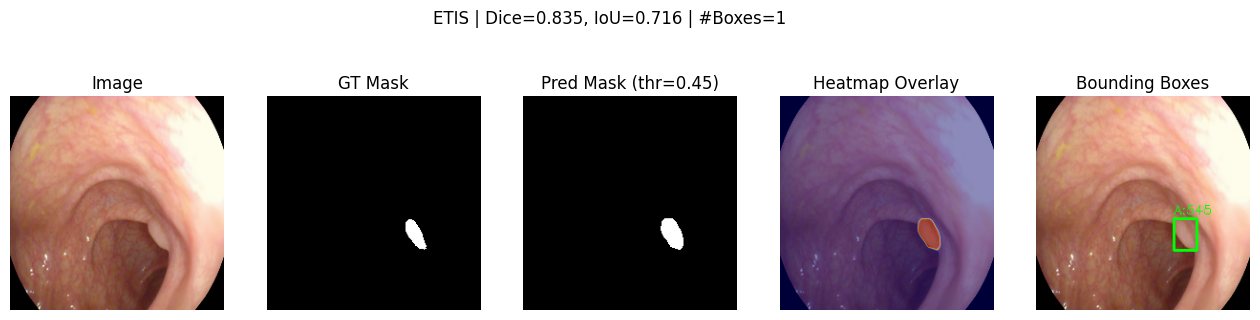

In [ ]:
# =========================
# ADD-ON: HEATMAP + MULTI-BBOX VISUALIZATION
# =========================

import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_bboxes_from_mask(bin_mask, min_area=80):
    """
    Returns list of bounding boxes (x1,y1,x2,y2) for each connected component.
    min_area filters tiny false positives.
    """
    bin_mask = (bin_mask > 0).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(bin_mask, connectivity=8)

    bboxes = []
    for i in range(1, num_labels):  # skip background label 0
        x, y, w, h, area = stats[i]
        if area >= min_area:
            bboxes.append((x, y, x + w, y + h, area))

    # optional: sort big->small
    bboxes.sort(key=lambda x: x[-1], reverse=True)
    return bboxes

def apply_heatmap_on_image(rgb_img, prob_map, alpha=0.45):
    """
    rgb_img: HxWx3 (uint8)
    prob_map: HxW float in [0,1]
    returns blended image with heatmap overlay
    """
    heat = (prob_map * 255).astype(np.uint8)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)      # BGR
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)          # RGB

    blended = (alpha * heat + (1 - alpha) * rgb_img).astype(np.uint8)
    return blended

def show_samples_heatmap_bbox(pairs, k=5, thr=0.5, min_area=80):
    idxs = np.linspace(0, len(pairs)-1, k, dtype=int) if len(pairs) >= k else range(len(pairs))

    for i in idxs:
        img_path, mask_path = pairs[i]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt = (gt > 128).astype(np.uint8)

        # transform like val
        aug = val_transform(image=img, mask=gt.astype(np.float32))
        x = aug["image"].unsqueeze(0).to(device)
        gt_t = aug["mask"].numpy().astype(np.uint8)

        # predict probability map
        with torch.no_grad():
            logits, _ = model(x, alpha=0.0)
            prob = torch.sigmoid(logits)[0, 0].cpu().numpy()  # HxW float
            pred = (prob > thr).astype(np.uint8)

        # resize original image to match pred size for clean overlay
        img_rs = cv2.resize(img, (pred.shape[1], pred.shape[0]))

        # heatmap overlay
        heat_overlay = apply_heatmap_on_image(img_rs, prob, alpha=0.45)

        # bounding boxes from predicted mask (MULTIPLE)
        bboxes = get_bboxes_from_mask(pred, min_area=min_area)

        bbox_img = img_rs.copy()
        for (x1, y1, x2, y2, area) in bboxes:
            cv2.rectangle(bbox_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(bbox_img, f"A:{area}", (x1, max(0, y1-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 1)

        # metrics
        d, j = dice_iou(pred, gt_t)

        plt.figure(figsize=(16, 4))
        plt.suptitle(f"ETIS | Dice={d:.3f}, IoU={j:.3f} | #Boxes={len(bboxes)}", fontsize=12)

        plt.subplot(1, 5, 1); plt.title("Image"); plt.imshow(img_rs); plt.axis("off")
        plt.subplot(1, 5, 2); plt.title("GT Mask"); plt.imshow(gt_t, cmap="gray"); plt.axis("off")
        plt.subplot(1, 5, 3); plt.title(f"Pred Mask (thr={thr})"); plt.imshow(pred, cmap="gray"); plt.axis("off")
        plt.subplot(1, 5, 4); plt.title("Heatmap Overlay"); plt.imshow(heat_overlay); plt.axis("off")
        plt.subplot(1, 5, 5); plt.title("Bounding Boxes"); plt.imshow(bbox_img); plt.axis("off")

        plt.show()

# Run it
show_samples_heatmap_bbox(etis_pairs, k=5, thr=0.45, min_area=80)



In [ ]:
# =========================
# PATCH: Watershed-based multi-instance splitting + bboxes
# =========================
import cv2
import numpy as np

def watershed_bboxes(rgb_img, prob_map,
                     thr=0.40,          # low threshold to catch small regions
                     peak_ratio=0.45,    # controls splitting (0.35-0.55)
                     min_area=40,        # keep small polyps
                     conf_thr=0.50,      # mean prob inside instance
                     open_ks=3):
    """
    Returns: bboxes, split_mask (binary), markers_ws (labeled)
    bbox: (x1,y1,x2,y2,area,mean_conf)
    """

    # 1) binary mask from probability
    bin_mask = (prob_map > thr).astype(np.uint8) * 255

    # 2) remove tiny noise
    if open_ks and open_ks > 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ks, open_ks))
        bin_mask = cv2.morphologyEx(bin_mask, cv2.MORPH_OPEN, k, iterations=1)

    # 3) sure background
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    sure_bg = cv2.dilate(bin_mask, k, iterations=2)

    # 4) distance transform -> sure foreground peaks
    dist = cv2.distanceTransform(bin_mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, peak_ratio * dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)

    # 5) markers for watershed
    num_labels, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # watershed needs BGR image
    img_bgr = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
    markers_ws = cv2.watershed(img_bgr, markers.copy())  # boundaries = -1

    # 6) extract instances + bboxes
    bboxes = []
    for lab in range(2, markers_ws.max() + 1):
        inst = (markers_ws == lab).astype(np.uint8)
        area = int(inst.sum())
        if area < min_area:
            continue

        mean_conf = float(prob_map[inst == 1].mean()) if area > 0 else 0.0
        if mean_conf < conf_thr:
            continue

        ys, xs = np.where(inst == 1)
        x1, x2 = xs.min(), xs.max()
        y1, y2 = ys.min(), ys.max()

        bboxes.append((x1, y1, x2 + 1, y2 + 1, area, mean_conf))

    # sort by area
    bboxes.sort(key=lambda t: t[4], reverse=True)

    split_mask = (markers_ws > 1).astype(np.uint8)
    return bboxes, split_mask, markers_ws


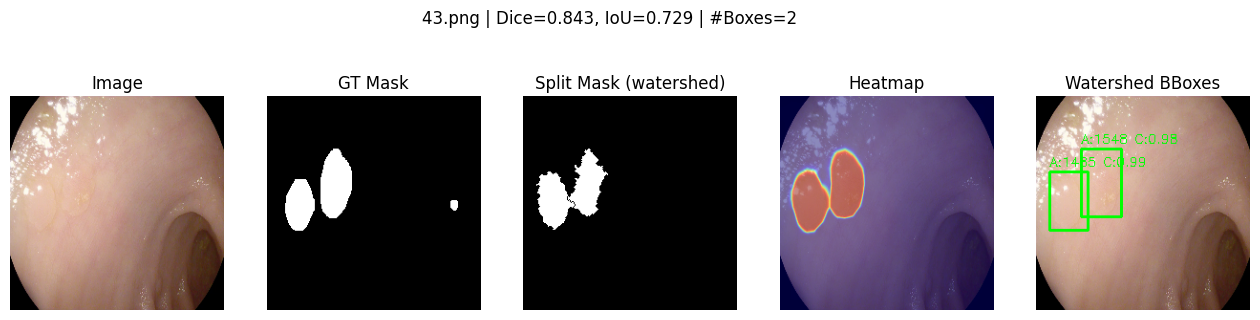

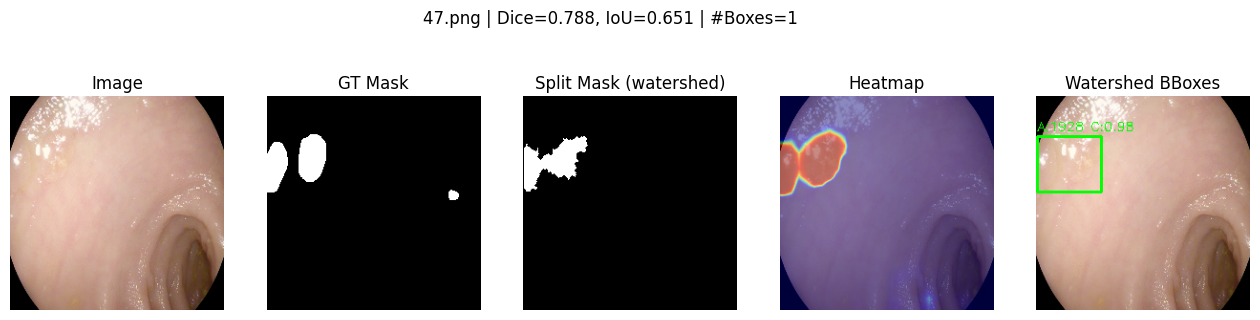

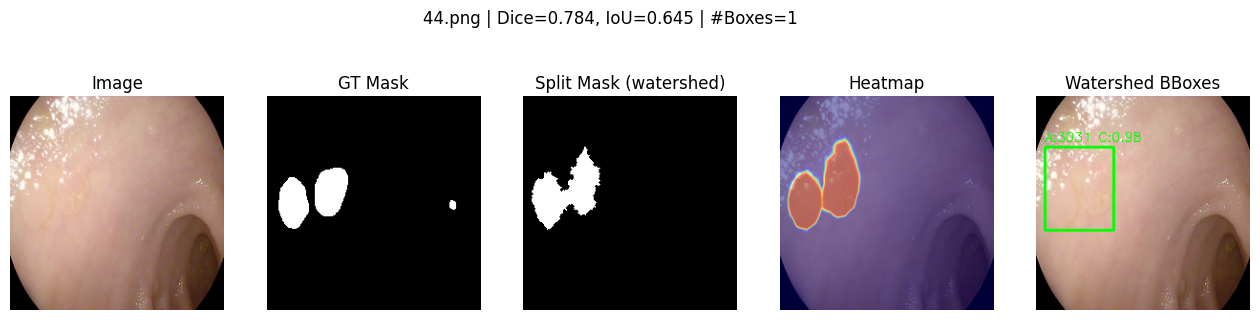

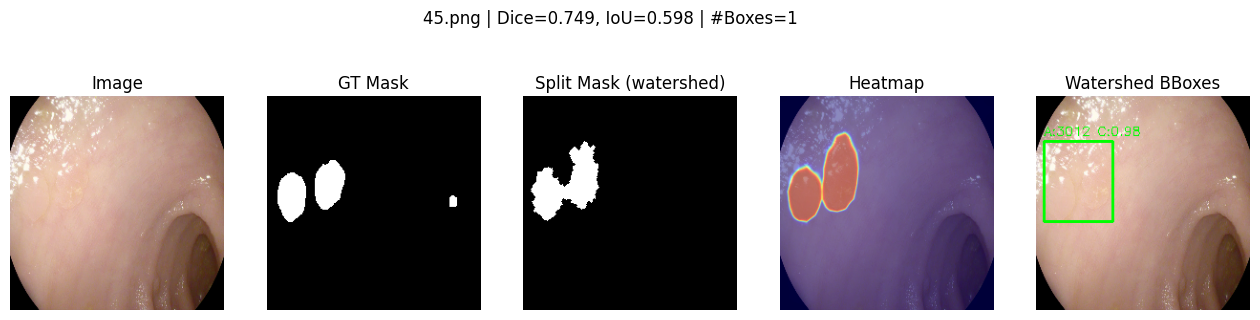

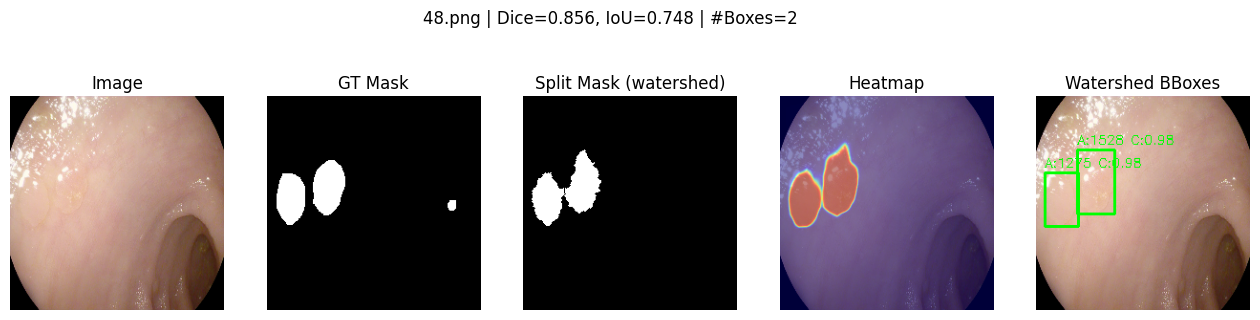

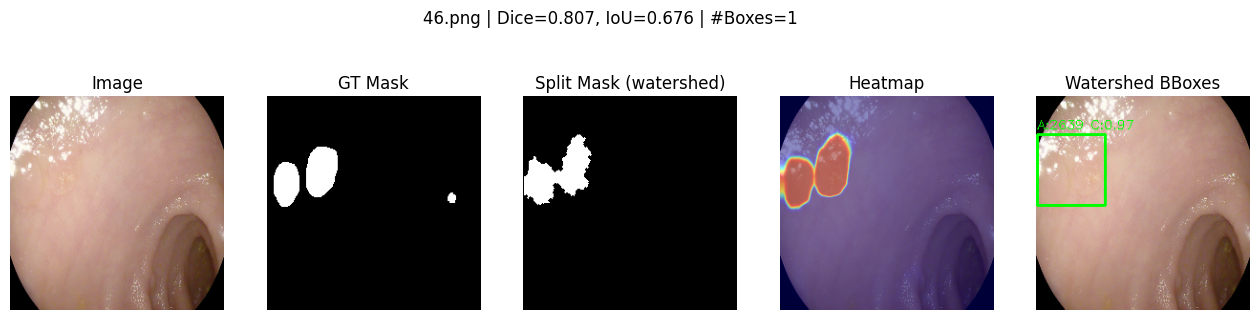

In [ ]:
# =========================
# SHOW MULTI-POLYP CASES with Watershed boxes
# =========================
import matplotlib.pyplot as plt
import torch

def show_multi_cases_watershed(pairs, thr=0.40, peak_ratio=0.45, min_area=40, conf_thr=0.50):
    for (img_path, mask_path) in pairs:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt = (gt > 128).astype(np.uint8)

        aug = val_transform(image=img, mask=gt.astype(np.float32))
        x = aug["image"].unsqueeze(0).to(device)
        gt_t = aug["mask"].numpy().astype(np.uint8)

        with torch.no_grad():
            logits, _ = model(x, alpha=0.0)
            prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

        img_rs = cv2.resize(img, (prob.shape[1], prob.shape[0]))
        heat_overlay = apply_heatmap_on_image(img_rs, prob, alpha=0.45)

        bboxes, split_mask, _ = watershed_bboxes(
            img_rs, prob, thr=thr, peak_ratio=peak_ratio,
            min_area=min_area, conf_thr=conf_thr, open_ks=3
        )

        bbox_img = img_rs.copy()
        for (x1, y1, x2, y2, area, mconf) in bboxes:
            cv2.rectangle(bbox_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(bbox_img, f"A:{area} C:{mconf:.2f}", (x1, max(0, y1-6)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,255,0), 1)

        # Dice/IoU (reporting) using stable thr=0.5
        pred = (prob > 0.5).astype(np.uint8)
        d, j = dice_iou(pred, gt_t)

        plt.figure(figsize=(16, 4))
        plt.suptitle(f"{Path(img_path).name} | Dice={d:.3f}, IoU={j:.3f} | #Boxes={len(bboxes)}", fontsize=12)

        plt.subplot(1, 5, 1); plt.title("Image"); plt.imshow(img_rs); plt.axis("off")
        plt.subplot(1, 5, 2); plt.title("GT Mask"); plt.imshow(gt_t, cmap="gray"); plt.axis("off")
        plt.subplot(1, 5, 3); plt.title("Split Mask (watershed)"); plt.imshow(split_mask, cmap="gray"); plt.axis("off")
        plt.subplot(1, 5, 4); plt.title("Heatmap"); plt.imshow(heat_overlay); plt.axis("off")
        plt.subplot(1, 5, 5); plt.title("Watershed BBoxes"); plt.imshow(bbox_img); plt.axis("off")
        plt.show()

multi_pairs = [(p[0], p[1]) for p in multi_gt]
show_multi_cases_watershed(multi_pairs, thr=0.40, peak_ratio=0.45, min_area=40, conf_thr=0.50)

In [ ]:
# =========================
# BLOCK: COPY-PASTE MULTI-POLYP AUGMENTATION
# =========================

import random
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

def extract_polyp_crop(img, mask, min_area=150):
    """
    Extracts a polyp crop (img_crop, mask_crop) using the mask bounding box.
    Returns None if mask too small.
    """
    mask_bin = (mask > 0).astype(np.uint8)
    ys, xs = np.where(mask_bin == 1)
    if len(xs) == 0:
        return None

    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    if area < min_area:
        return None

    img_crop = img[y1:y2+1, x1:x2+1].copy()
    mask_crop = mask_bin[y1:y2+1, x1:x2+1].copy()
    return img_crop, mask_crop

def paste_crop(img, mask, img_crop, mask_crop):
    """
    Pastes crop into image at random location. Updates mask by OR.
    """
    H, W = img.shape[:2]
    h, w = img_crop.shape[:2]

    if h >= H or w >= W:
        return img, mask

    # random top-left location
    x = random.randint(0, W - w)
    y = random.randint(0, H - h)

    # paste only where mask_crop==1
    roi = img[y:y+h, x:x+w].copy()
    roi[mask_crop == 1] = img_crop[mask_crop == 1]
    img[y:y+h, x:x+w] = roi

    # update mask (union)
    mask[y:y+h, x:x+w] = np.maximum(mask[y:y+h, x:x+w], mask_crop.astype(mask.dtype))
    return img, mask


class PolypDatasetMulti(Dataset):
    """
    Like your PolypDataset, but with optional copy-paste augmentation
    to simulate MULTIPLE polyps per image.
    """
    def __init__(self, pairs, transform=None, copy_paste_p=0.35, min_area=150):
        self.pairs = pairs
        self.transform = transform
        self.copy_paste_p = copy_paste_p
        self.min_area = min_area

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 128).astype(np.uint8)

        # -----------------------------
        # COPY-PASTE another polyp blob
        # -----------------------------
        if random.random() < self.copy_paste_p:
            j = random.randint(0, len(self.pairs) - 1)
            img_path2, mask_path2 = self.pairs[j]

            img2 = cv2.imread(img_path2)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

            mask2 = cv2.imread(mask_path2, cv2.IMREAD_GRAYSCALE)
            mask2 = (mask2 > 128).astype(np.uint8)

            crop = extract_polyp_crop(img2, mask2, min_area=self.min_area)
            if crop is not None:
                img_crop, mask_crop = crop
                img, mask = paste_crop(img, mask, img_crop, mask_crop)

        # transform
        if self.transform:
            augmented = self.transform(image=img, mask=mask.astype(np.float32))
            img = augmented["image"]
            mask = augmented["mask"].unsqueeze(0)  # [1,H,W]

        return img, mask


print("✅ PolypDatasetMulti (copy-paste) defined!")


✅ PolypDatasetMulti (copy-paste) defined!


In [ ]:
# =========================
# REBUILD TRAIN LOADER WITH MULTI-POLYP AUG
# =========================
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_pairs, val_pairs = train_test_split(source_pairs, test_size=0.2, random_state=42)

train_ds = PolypDatasetMulti(train_pairs, transform=train_transform, copy_paste_p=0.35, min_area=150)
val_ds   = PolypDataset(val_pairs, transform=val_transform)  # keep val clean

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

print("✅ Train loader updated with multi-polyp augmentation!")


✅ Train loader updated with multi-polyp augmentation!


In [ ]:
# =========================
# NEXT: Fine-tune with Multi-Polyp Aug (resume from BEST)
# =========================
import torch
from pathlib import Path

# Load BEST weights you already saved (from earlier training)
BEST_PATH = "/content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3.pth"
assert Path(BEST_PATH).exists(), f"❌ Best model not found: {BEST_PATH}"

model.load_state_dict(torch.load(BEST_PATH, map_location=device))
model.to(device)
model.train()
print("✅ Loaded BEST model, ready to fine-tune with multi-polyp augmentation")

# Lower LR for fine-tuning (important)
for g in optimizer.param_groups:
    g["lr"] = 1e-4  # fine-tune LR (smaller than before)

print("✅ LR set to 1e-4 for fine-tuning")

# Fine-tune for 5 epochs (fast)
dann_train_resume(
    model,
    train_loader,
    target_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs=5,   # only 5 epochs fine-tune
    ckpt_path="/content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt_multi.pth",
    best_path="/content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3_multi.pth"
)


✅ Loaded BEST model, ready to fine-tune with multi-polyp augmentation
✅ LR set to 1e-4 for fine-tuning
ℹ️ No checkpoint found. Starting fresh.


Epoch 1/5: 100%|██████████| 142/142 [02:05<00:00,  1.13it/s, SegLoss=0.3325, DomLoss=1.4195, Alpha=0.76]


📌 Epoch 1 — Val Dice: 0.8319 | Best: 0.0000
🏆 Saved BEST model to: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3_multi.pth
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt_multi.pth (epoch=1, best_dice=0.8319)


Epoch 2/5: 100%|██████████| 142/142 [02:07<00:00,  1.12it/s, SegLoss=0.4639, DomLoss=1.4054, Alpha=0.96]


📌 Epoch 2 — Val Dice: 0.8271 | Best: 0.8319
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt_multi.pth (epoch=2, best_dice=0.8319)


Epoch 3/5: 100%|██████████| 142/142 [02:10<00:00,  1.09it/s, SegLoss=0.4514, DomLoss=1.3873, Alpha=1.00]


📌 Epoch 3 — Val Dice: 0.8660 | Best: 0.8319
🏆 Saved BEST model to: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3_multi.pth
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt_multi.pth (epoch=3, best_dice=0.8660)


Epoch 4/5: 100%|██████████| 142/142 [02:10<00:00,  1.09it/s, SegLoss=0.2191, DomLoss=1.3933, Alpha=1.00]


📌 Epoch 4 — Val Dice: 0.8890 | Best: 0.8660
🏆 Saved BEST model to: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3_multi.pth
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt_multi.pth (epoch=4, best_dice=0.8890)


Epoch 5/5: 100%|██████████| 142/142 [02:12<00:00,  1.07it/s, SegLoss=0.1017, DomLoss=1.4170, Alpha=1.00]


📌 Epoch 5 — Val Dice: 0.8917 | Best: 0.8890
🏆 Saved BEST model to: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3_multi.pth
💾 Checkpoint saved: /content/drive/MyDrive/polyp_dann_checkpoints/dann_deeplabv3_ckpt_multi.pth (epoch=5, best_dice=0.8917)

✅ Training finished.
Best Val Dice: 0.8917


0.8916690383929706

✅ Loaded: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3_multi.pth
🌍 ETIS Dice (NEW model): 0.8539
🌍 ETIS Mean Dice (thr=0.5): 0.8539
🌍 ETIS Mean IoU  (thr=0.5): 0.7788


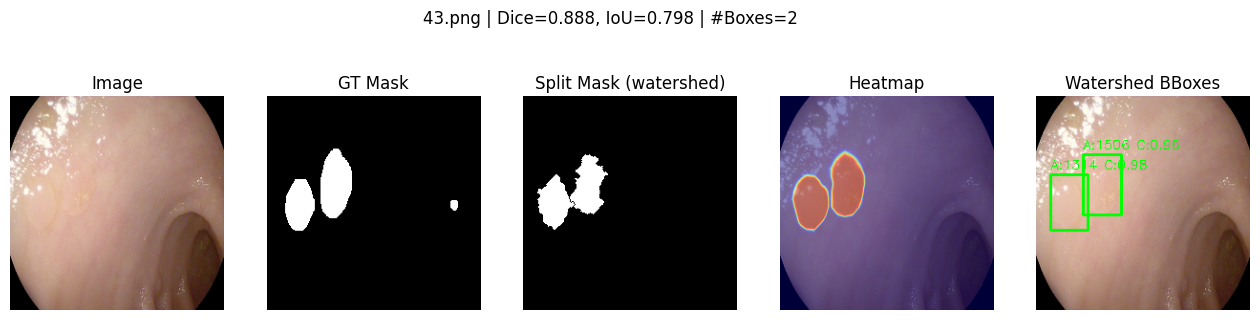

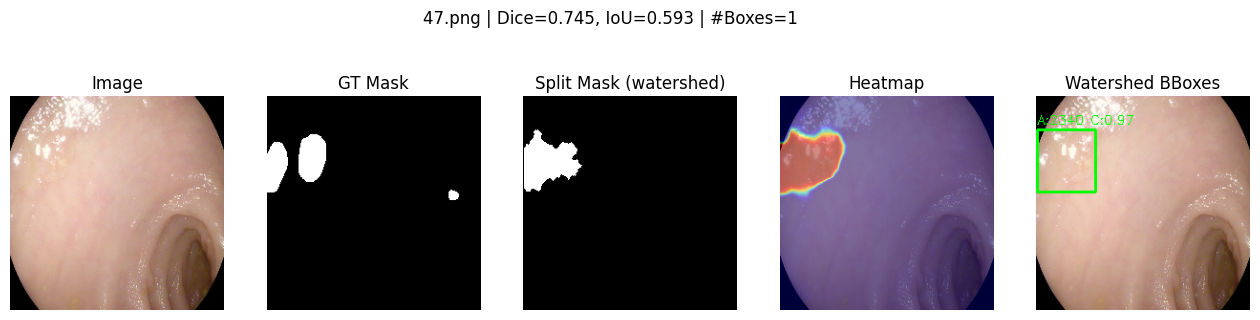

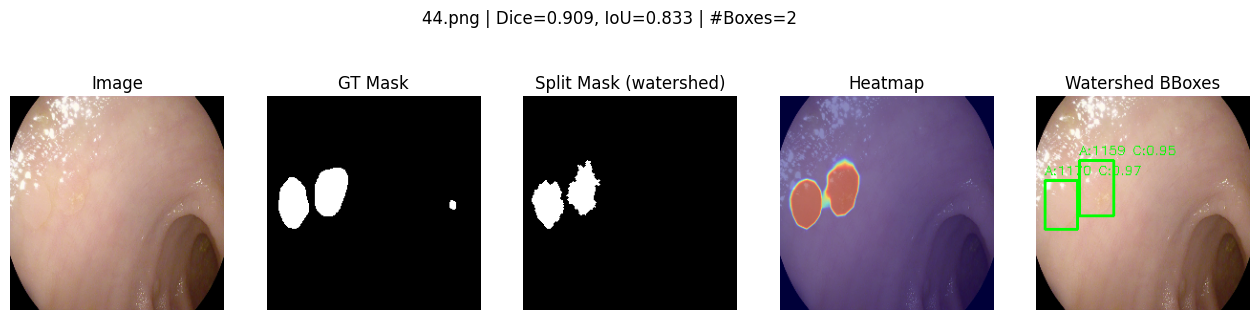

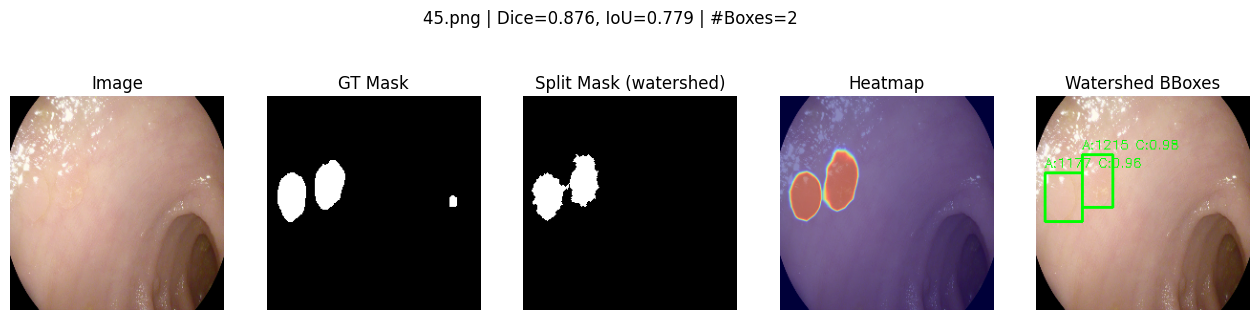

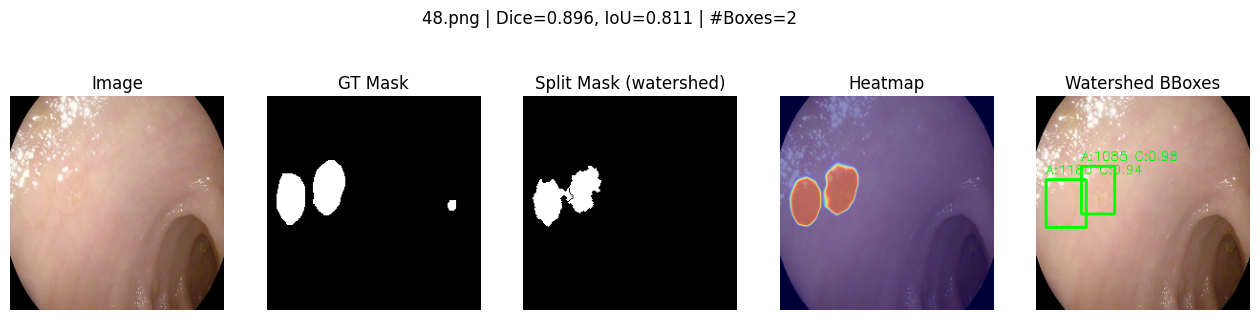

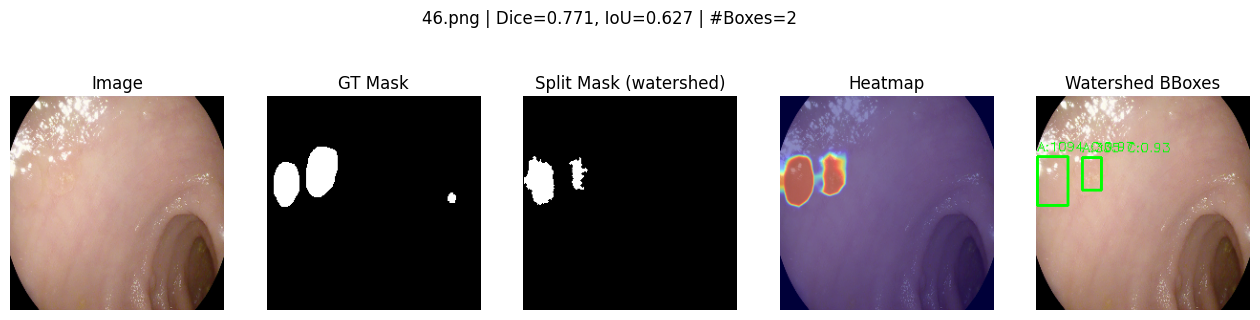

In [ ]:
# =========================
# NEXT: Evaluate NEW multi-polyp fine-tuned model on ETIS + visualize multi cases
# =========================
import torch
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader

# 1) Load new best model
BEST_MULTI = "/content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3_multi.pth"
assert Path(BEST_MULTI).exists(), f"❌ Not found: {BEST_MULTI}"

model.load_state_dict(torch.load(BEST_MULTI, map_location=device))
model.eval()
print("✅ Loaded:", BEST_MULTI)

# 2) ETIS loader (reuse your etis_pairs from before)
etis_eval_ds = PolypDataset(etis_pairs, transform=val_transform)
etis_eval_loader = DataLoader(etis_eval_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# 3) ETIS Dice (same validate_model)
etis_dice = validate_model(model, etis_eval_loader)
print(f"🌍 ETIS Dice (NEW model): {etis_dice:.4f}")

# 4) ETIS Dice + IoU at a chosen threshold (use your eval_dice_iou_full)
mean_dice, mean_iou = eval_dice_iou_full(model, etis_pairs, thr=0.5)
print(f"🌍 ETIS Mean Dice (thr=0.5): {mean_dice:.4f}")
print(f"🌍 ETIS Mean IoU  (thr=0.5): {mean_iou:.4f}")

# 5) Visualize multi-polyp GT cases with watershed
multi_pairs = [(p[0], p[1]) for p in multi_gt]  # from your earlier multi_gt list
show_multi_cases_watershed(multi_pairs, thr=0.40, peak_ratio=0.45, min_area=40, conf_thr=0.50)


In [ ]:
# =========================
# DOWNLOAD BEST MODEL (multi-polyp)
# =========================
from google.colab import files
from pathlib import Path

BEST_MULTI = "/content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3_multi.pth"
assert Path(BEST_MULTI).exists(), "❌ best_dann_deeplabv3_multi.pth not found!"

files.download(BEST_MULTI)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Loaded: /content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3_multi.pth
✅ ETIS pairs: 196
✅ Using existing source_pairs for CVC: 1420

📌 CVC (Source) (thr=0.5)
Macro (mean per-image): {'dice': 0.92, 'iou': 0.8641, 'precision': 0.908, 'recall': 0.9426, 'spec': 0.9928, 'f1': 0.9249, 'f2': 0.9368}
Micro (global pixels) : {'dice': 0.942, 'iou': 0.8903, 'precision': 0.9279, 'recall': 0.9565, 'spec': 0.9931, 'f1': 0.942, 'f2': 0.9506}

📌 ETIS (Target) (thr=0.5)
Macro (mean per-image): {'dice': 0.8539, 'iou': 0.7788, 'precision': 0.826, 'recall': 0.9139, 'spec': 0.9929, 'f1': 0.874, 'f2': 0.9045}
Micro (global pixels) : {'dice': 0.9114, 'iou': 0.8372, 'precision': 0.8675, 'recall': 0.96, 'spec': 0.993, 'f1': 0.9114, 'f2': 0.9399}

💾 Saved CSVs to: /content/drive/MyDrive/polyp_dann_reports


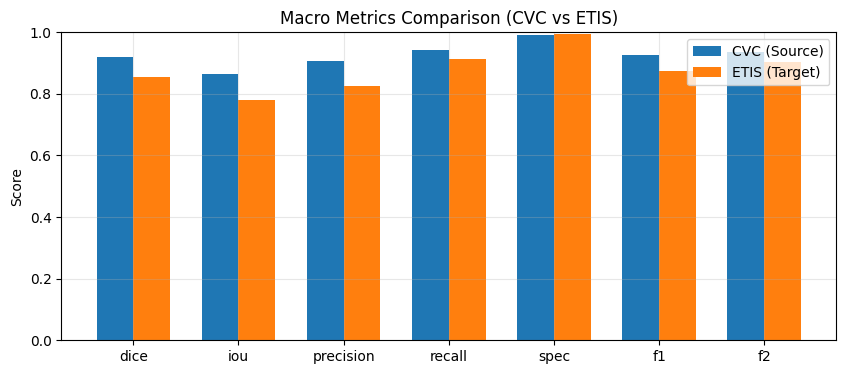

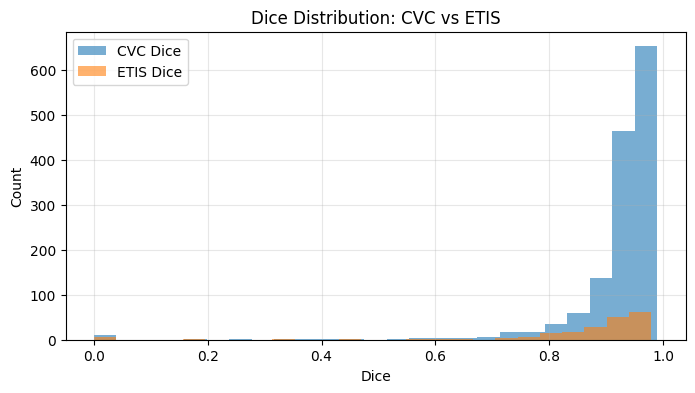


✅ Done. Use these for your report:
 - Macro comparison bar chart
 - Dice distribution chart
 - Per-image CSVs in Drive: /content/drive/MyDrive/polyp_dann_reports


In [ ]:
# =========================
# FULL COMPARISON: CVC vs ETIS + F1/F2 + GRAPHS + CSVs
# =========================
import cv2, numpy as np, torch, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --------- Load best model ----------
BEST_MULTI = "/content/drive/MyDrive/polyp_dann_checkpoints/best_dann_deeplabv3_multi.pth"
assert Path(BEST_MULTI).exists(), f"❌ Not found: {BEST_MULTI}"
model.load_state_dict(torch.load(BEST_MULTI, map_location=device))
model.to(device).eval()
print("✅ Loaded:", BEST_MULTI)

# --------- Pair builders ----------
def collect_pairs_simple(img_dir, mask_dir):
    img_exts = (".png",".jpg",".jpeg",".tif",".tiff",".bmp")
    masks = {m.stem.lower(): m for m in Path(mask_dir).glob("*") if m.suffix.lower() in img_exts}
    pairs = []
    for im in Path(img_dir).glob("*"):
        if im.suffix.lower() in img_exts and im.stem.lower() in masks:
            pairs.append((str(im), str(masks[im.stem.lower()])))
    return sorted(pairs)

def collect_pairs_multi_dirs(img_dirs, mask_dirs):
    img_exts = (".png",".jpg",".jpeg",".tif",".tiff",".bmp")
    img_files = []
    for d in img_dirs:
        d = Path(d)
        if d.exists():
            img_files += [p for p in d.glob("*") if p.suffix.lower() in img_exts]

    mask_map = {}
    for d in mask_dirs:
        d = Path(d)
        if d.exists():
            for m in d.glob("*"):
                if m.suffix.lower() in img_exts:
                    mask_map[m.stem.lower()] = m

    pairs = []
    for im in sorted(img_files):
        k = im.stem.lower()
        if k in mask_map:
            pairs.append((str(im), str(mask_map[k])))
    return pairs

# --------- Build ETIS pairs ----------
etis_img_dir  = "/content/data/ETIS_RAW/images"
etis_mask_dir = "/content/data/ETIS_RAW/masks"
etis_pairs = collect_pairs_simple(etis_img_dir, etis_mask_dir)
print("✅ ETIS pairs:", len(etis_pairs))

# --------- Build CVC pairs ----------
# Prefer existing source_pairs if available, else auto-discover folders
try:
    cvc_pairs = source_pairs
    print("✅ Using existing source_pairs for CVC:", len(cvc_pairs))
except NameError:
    cvc_img_dirs  = ["/content/data/images", "/content/data/PNG/Original", "/content/data/TIF/Original"]
    cvc_mask_dirs = ["/content/data/masks",  "/content/data/PNG/Ground Truth", "/content/data/TIF/Ground Truth"]
    cvc_pairs = collect_pairs_multi_dirs(cvc_img_dirs, cvc_mask_dirs)
    print("✅ Built CVC pairs:", len(cvc_pairs))

assert len(cvc_pairs) > 0 and len(etis_pairs) > 0, "❌ CVC/ETIS pairs empty."

# --------- Metrics helpers (adds F1 + F2) ----------
def compute_metrics(pred_bin, gt_bin, beta=2.0, eps=1e-6):
    pred = pred_bin.astype(np.uint8)
    gt   = gt_bin.astype(np.uint8)

    TP = int((pred & gt).sum())
    FP = int((pred & (1 - gt)).sum())
    FN = int(((1 - pred) & gt).sum())
    TN = int(((1 - pred) & (1 - gt)).sum())

    precision = (TP + eps) / (TP + FP + eps)
    recall    = (TP + eps) / (TP + FN + eps)   # sensitivity
    spec      = (TN + eps) / (TN + FP + eps)

    # Dice == F1 for binary segmentation masks
    dice = (2*TP + eps) / (2*TP + FP + FN + eps)
    iou  = (TP + eps) / (TP + FP + FN + eps)

    f1 = (2 * precision * recall + eps) / (precision + recall + eps)
    b2 = beta * beta
    f2 = ((1 + b2) * precision * recall + eps) / (b2 * precision + recall + eps)

    return float(dice), float(iou), float(precision), float(recall), float(spec), float(f1), float(f2), TP, FP, FN, TN

@torch.no_grad()
def predict_prob(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    dummy = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
    aug = val_transform(image=img, mask=dummy)
    x = aug["image"].unsqueeze(0).to(device)

    logits, _ = model(x, alpha=0.0)
    prob = torch.sigmoid(logits)[0,0].cpu().numpy()
    return prob

def load_gt(mask_path, out_hw):
    gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt = (gt > 128).astype(np.uint8)
    gt = cv2.resize(gt, (out_hw[1], out_hw[0]), interpolation=cv2.INTER_NEAREST)
    return gt

def eval_dataset(pairs, thr=0.5, name="DATA"):
    rows = []
    sums = {"TP":0,"FP":0,"FN":0,"TN":0}
    lists = {"dice":[], "iou":[], "precision":[], "recall":[], "spec":[], "f1":[], "f2":[]}

    for img_path, mask_path in pairs:
        prob = predict_prob(img_path)
        pred = (prob > thr).astype(np.uint8)
        gt   = load_gt(mask_path, pred.shape)

        dice,iou,prec,rec,spec,f1,f2,TP,FP,FN,TN = compute_metrics(pred, gt, beta=2.0)
        for k,v in [("dice",dice),("iou",iou),("precision",prec),("recall",rec),("spec",spec),("f1",f1),("f2",f2)]:
            lists[k].append(v)

        sums["TP"] += TP; sums["FP"] += FP; sums["FN"] += FN; sums["TN"] += TN

        rows.append({
            "image": Path(img_path).name,
            "dice": dice, "iou": iou,
            "precision": prec, "recall": rec, "specificity": spec,
            "f1": f1, "f2": f2,
            "TP":TP,"FP":FP,"FN":FN,"TN":TN
        })

    df = pd.DataFrame(rows)

    # Macro means (average per-image)
    macro = {k: float(np.mean(v)) for k,v in lists.items()}

    # Micro (global totals)
    TP, FP, FN, TN = sums["TP"], sums["FP"], sums["FN"], sums["TN"]
    eps = 1e-6
    micro_prec = (TP+eps)/(TP+FP+eps)
    micro_rec  = (TP+eps)/(TP+FN+eps)
    micro_spec = (TN+eps)/(TN+FP+eps)
    micro_dice = (2*TP+eps)/(2*TP+FP+FN+eps)
    micro_iou  = (TP+eps)/(TP+FP+FN+eps)
    micro_f1   = (2*micro_prec*micro_rec+eps)/(micro_prec+micro_rec+eps)
    b2 = 4.0
    micro_f2   = ((1+b2)*micro_prec*micro_rec+eps)/(b2*micro_prec+micro_rec+eps)

    micro = {
        "dice": float(micro_dice), "iou": float(micro_iou),
        "precision": float(micro_prec), "recall": float(micro_rec), "spec": float(micro_spec),
        "f1": float(micro_f1), "f2": float(micro_f2)
    }

    print(f"\n📌 {name} (thr={thr})")
    print("Macro (mean per-image):", {k: round(v,4) for k,v in macro.items()})
    print("Micro (global pixels) :", {k: round(v,4) for k,v in micro.items()})

    return df, macro, micro

# --------- Run evaluation ----------
THR = 0.5
df_cvc, macro_cvc, micro_cvc   = eval_dataset(cvc_pairs,  thr=THR, name="CVC (Source)")
df_etis, macro_etis, micro_etis = eval_dataset(etis_pairs, thr=THR, name="ETIS (Target)")

# --------- Save CSVs ----------
out_dir = Path("/content/drive/MyDrive/polyp_dann_reports")
out_dir.mkdir(parents=True, exist_ok=True)

df_cvc.to_csv(out_dir/"cvc_metrics_per_image.csv", index=False)
df_etis.to_csv(out_dir/"etis_metrics_per_image.csv", index=False)
print("\n💾 Saved CSVs to:", out_dir)

# --------- Comparison graphs (Macro) ----------
metrics = ["dice","iou","precision","recall","spec","f1","f2"]
cvc_vals  = [macro_cvc[m]  for m in metrics]
etis_vals = [macro_etis[m] for m in metrics]

x = np.arange(len(metrics))
w = 0.35

plt.figure(figsize=(10,4))
plt.bar(x - w/2, cvc_vals,  width=w, label="CVC (Source)")
plt.bar(x + w/2, etis_vals, width=w, label="ETIS (Target)")
plt.xticks(x, metrics, rotation=0)
plt.ylim(0, 1.0)
plt.title("Macro Metrics Comparison (CVC vs ETIS)")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# --------- Dice distribution comparison ----------
plt.figure(figsize=(8,4))
plt.hist(df_cvc["dice"].values,  bins=25, alpha=0.6, label="CVC Dice")
plt.hist(df_etis["dice"].values, bins=25, alpha=0.6, label="ETIS Dice")
plt.title("Dice Distribution: CVC vs ETIS")
plt.xlabel("Dice")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("\n✅ Done. Use these for your report:")
print(" - Macro comparison bar chart")
print(" - Dice distribution chart")
print(" - Per-image CSVs in Drive:", out_dir)